<a href="https://colab.research.google.com/github/samochkin/our-teem/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22RecSys_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Новый раздел

In [27]:
import torch
from torch import nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(self._conv_block(in_channels, feature))
            in_channels = feature
        self.bottleneck = self._conv_block(features[-1], features[-1] * 2)

        self.decoder = nn.ModuleList()
        # torch.Size([32, 64, 2]), torch.Size([32, 32, 4]), torch.Size([32, 16, 8]), torch.Size([32, 8, 16])
        # [8, 16, 32, 64]
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose1d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._conv_block(feature * 2, feature, div_by=1))

        self.final_layer = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = nn.MaxPool1d(kernel_size=2, stride=2)(x)
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        # print(f"Shapes: {[s.shape for s in skip_connections]}")
        # print(x.shape)
        # print(self.decoder)
        for idx in range(0, len(self.decoder), 2):
            # print(f"{self.decoder[idx]=}")
            # print(f"{x.shape=}")
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2] # 1: 32, 8, 8
            # print(skip_connection.shape, x.shape)

            x = torch.cat((skip_connection, x), dim=1)
            # print(f"2: {x.shape=}")
            # print(f"{self.decoder[idx + 1]=}")
            x = self.decoder[idx + 1](x)
            # print(f"{x.shape=}")

        return self.final_layer(x)

    @staticmethod
    def _conv_block(in_channels, out_channels, div_by = 1):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels // div_by, kernel_size=3, padding=1),
            nn.ReLU(),
        )

model = UNet(in_channels=1, out_channels=1, features=[1, 8, 16, 64])
print(model)

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
  )
  (bottleneck): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(3

In [4]:
file_path = 'sessions.pickle'

In [5]:
from torch.utils.data import DataLoader

In [7]:
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.optim as optim

def load_dataset(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден")
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

file_path = '/content/sessions.pickle'

if not os.path.exists(file_path):
    print(f"Файл {file_path} не найден. Проверьте путь.")
else:
    clean_logs = load_dataset(file_path)
    clean_logs = torch.Tensor(clean_logs['screen_seq']).view(100000, 16)


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")

def linear_beta_schedule(timesteps):
    beta_start = 1e-4
    beta_end = 2e-2
    return torch.linspace(beta_start, beta_end, timesteps)

timesteps = 1000
beta_schedule = linear_beta_schedule(timesteps)

def forward_diffusion_process(x, t, noise_schedule):
    beta_t = noise_schedule[t]
    noise = torch.randn_like(x)
    return torch.sqrt(1 - beta_t) * x + torch.sqrt(beta_t) * noise

def reverse_diffusion_step(x, t, noise_schedule):     ## Прменить логи и посмотерть что получится
    beta_t = noise_schedule[t]
    noise = torch.randn_like(x)
    sqrt_term = torch.sqrt(torch.clamp(1 - beta_t, min=1e-5))
    return (x - torch.sqrt(beta_t) * noise) / sqrt_term

# def reverse_diffusion_result(noisy_image, noise):     ## Прменить логи и посмотерть что получится
#     beta_t = noise_schedule[t]
#     noise = torch.randn_like(x)
#     sqrt_term = torch.sqrt(torch.clamp(1 - beta_t, min=1e-5))
#     return (x - torch.sqrt(beta_t) * noise) / sqrt_term


image = clean_logs #log.view(1,1,16)
noisy_image = forward_diffusion_process(image, 10, beta_schedule)
denoised_image = reverse_diffusion_step(noisy_image, 10, beta_schedule)


titles = ["Изначальное", "Зашумленное", "После диффузии"]




loss_function = nn.MSELoss()
predicted_noise = image
actual_noise = denoised_image
loss = loss_function(predicted_noise, actual_noise)

print(f"Loss: {loss.item()}")


Используется устройство: cuda
Loss: 0.0005987735348753631


In [ ]:
# model = UNet(in_channels= 1 , out_channels= 1, features=[8, 16, 32, 64])

# model(torch.randn(32, 1, 16)).shape

In [8]:
losses = []

In [9]:
model = UNet(in_channels= 1 , out_channels= 1, features=[8, 16, 32, 64]).to(device)
# print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-7)

epochs = 50
timesteps = 1000
beta_schedule = linear_beta_schedule(timesteps).to(device)
batch_size = 32
dataloader = DataLoader(clean_logs, batch_size=batch_size, shuffle=True)

for epoch in  range(epochs):
    print ( f"Epoch {epoch+ 1 } / {epochs} " )
    for batch_idx, images in  enumerate (dataloader):
        images = images.to(device)

        t = torch.randint( 0 , timesteps, (images.size( 1 ),)).to(device)
        noise_images = forward_diffusion_process(images, t, beta_schedule)
        noise = torch.randn_like(images)
        # print(t.shape, noise_images.shape)
        predicted_noise = model(noise_images.unsqueeze(1))

        loss = loss_function(predicted_noise, noise)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0 :
            print ( f"Batch {batch_idx} / { len (dataloader)} - Loss: {loss.item(): .4f} " )
    losses.append(loss.item())

Epoch 1 / 50 


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 16])) that is different to the input size (torch.Size([32, 1, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Выходные данные были обрезаны до нескольких последних строк (5000).
Batch 230 / 3125 - Loss:  1.0799 
Batch 240 / 3125 - Loss:  1.0380 
Batch 250 / 3125 - Loss:  1.0261 
Batch 260 / 3125 - Loss:  1.1608 
Batch 270 / 3125 - Loss:  0.9822 
Batch 280 / 3125 - Loss:  0.9982 
Batch 290 / 3125 - Loss:  0.9677 
Batch 300 / 3125 - Loss:  0.9306 
Batch 310 / 3125 - Loss:  1.0997 
Batch 320 / 3125 - Loss:  0.9862 
Batch 330 / 3125 - Loss:  1.0791 
Batch 340 / 3125 - Loss:  1.0650 
Batch 350 / 3125 - Loss:  0.9915 
Batch 360 / 3125 - Loss:  1.0581 
Batch 370 / 3125 - Loss:  1.0080 
Batch 380 / 3125 - Loss:  1.0773 
Batch 390 / 3125 - Loss:  1.0105 
Batch 400 / 3125 - Loss:  1.0574 
Batch 410 / 3125 - Loss:  1.1233 
Batch 420 / 3125 - Loss:  0.9360 
Batch 430 / 3125 - Loss:  1.1085 
Batch 440 / 3125 - Loss:  1.0006 
Batch 450 / 3125 - Loss:  1.1307 
Batch 460 / 3125 - Loss:  0.9790 
Batch 470 / 3125 - Loss:  0.9493 
Batch 480 / 3125 - Loss:  1.0778 
Batch 490 / 3125 - Loss:  1.1043 
Batch 500 / 31

In [10]:
import matplotlib.pyplot as plt

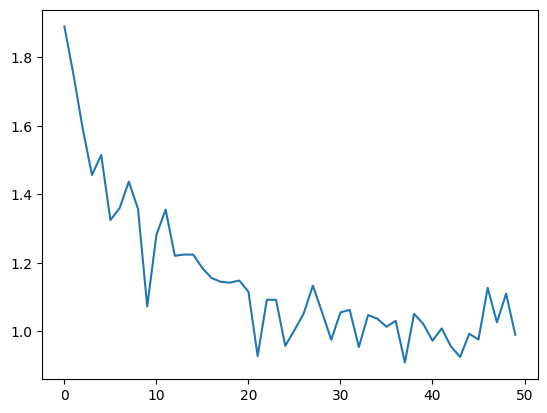

In [11]:
plt.plot(losses)

In [12]:
clean_logs[200]

tensor([544., 335.,  10., 402., 128., 545., 547., 547., 547., 547., 547., 547.,
        547., 547., 547., 547.])

In [13]:
noisy_session = [544, 335, 10, 335, 335, 16, 335, 10, 402, 545, 547., 547., 547., 547., 547., 547.]
# Шумная сессия

In [14]:
noisy_session = torch.Tensor(noisy_session).view(1, -1).unsqueeze(1).cuda()

In [15]:
noise = model(noisy_session)

In [16]:
noise
#шум

tensor([[[ 0.2262,  0.2775, -0.0040, -0.0615,  0.0689,  0.2227,  0.1801,
           0.2483,  0.2376,  0.0399,  0.0609, -0.0986, -0.1300, -0.1496,
           0.0495, -0.0936]]], device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [17]:
clean_session = noisy_session - noise

In [18]:
clean_session
# очищенная сессия

tensor([[[543.7737, 334.7224,  10.0040, 335.0615, 334.9311,  15.7773, 334.8199,
            9.7517, 401.7624, 544.9601, 546.9391, 547.0986, 547.1300, 547.1496,
          546.9506, 547.0936]]], device='cuda:0', grad_fn=<SubBackward0>)

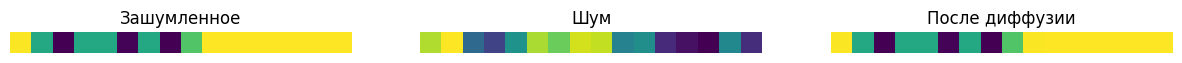

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Зашумленное", "Шум", "После диффузии"]

for i, img in enumerate([noisy_session.cpu(), noise.cpu().detach(), clean_session.cpu().detach()]):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(titles[i])
    axes[i].axis("off")

plt.show()

In [20]:
def forward_diffusion_process(x, t, noise_schedule):
    beta_t = noise_schedule[t]
    noise = torch.randn_like(x)
    return torch.sqrt(1 - beta_t) * x + torch.sqrt(beta_t) * noise

noise_slap = forward_diffusion_process(clean_logs[0],10, beta_schedule)
print(noise_slap)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [21]:
clean_logs = load_dataset(file_path)
clean_logs = torch.Tensor(clean_logs['screen_seq']).view(100000, 16)

tensor([[[544., 335., 278., 309., 106., 545., 547., 547., 547., 547., 547.,
          547., 547., 547., 547., 547.]]]) tensor([[[544.2263, 335.2776, 277.9961, 308.9385, 106.0689, 545.2227, 547.1801,
          547.2484, 547.2376, 547.0399, 547.0609, 546.9014, 546.8700, 546.8504,
          547.0494, 546.9064]]]) tensor([[[ 0.2262,  0.2775, -0.0040, -0.0615,  0.0689,  0.2227,  0.1801,
           0.2483,  0.2376,  0.0399,  0.0609, -0.0986, -0.1300, -0.1496,
           0.0495, -0.0936]]]) tensor([[[543.7737, 334.7224,  10.0040, 335.0615, 334.9311,  15.7773, 334.8199,
            9.7517, 401.7624, 544.9601, 546.9391, 547.0986, 547.1300, 547.1496,
          546.9506, 547.0936]]])


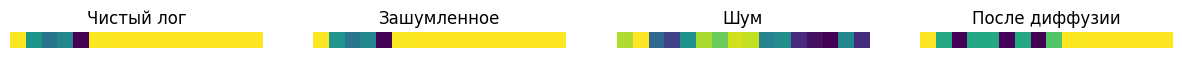

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
titles = ["Чистый лог","Зашумленное", "Шум", "После диффузии"]

for i, img in enumerate([clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().detach()]):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(titles[i])
    axes[i].axis("off")

print(clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().detach())

plt.show()

In [23]:
clean_logs[0].view(1, -1).unsqueeze(1).shape

torch.Size([1, 1, 16])

In [24]:
def reverse_diffusion_step(x, t, noise_schedule):
    beta_t = noise_schedule[t]
    noise = torch.randn_like(x)
    sqrt_term = torch.sqrt(torch.clamp(1 - beta_t, min=1e-5))
    return (x - torch.sqrt(beta_t) * noise) / sqrt_term

clean_session = forward_diffusion_process(noise_slap,10, beta_schedule)
print(clean_session)

NameError: name 'noise_slap' is not defined

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 3

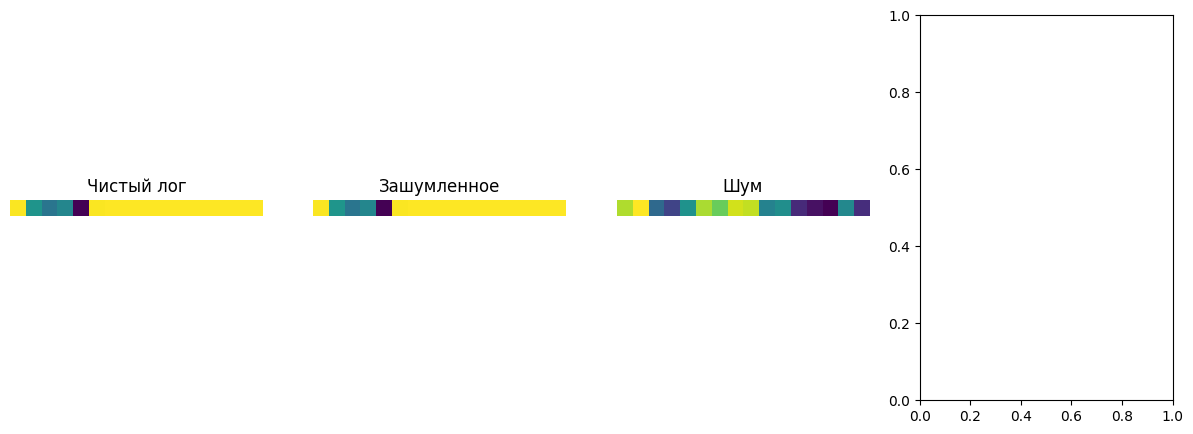

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
titles = ["Чистый лог","Зашумленное", "Шум", "После диффузии"]

for i, img in enumerate([clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().unsqueeze(0).unsqueeze(0).detach()]):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(titles[i])
    axes[i].axis("off")

print(clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().detach())

plt.show()

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 3

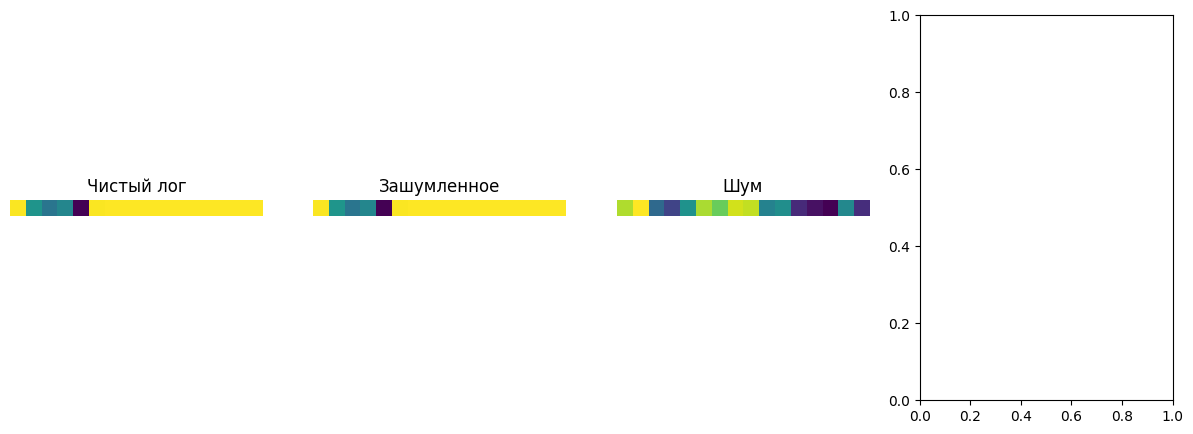

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
titles = ["Чистый лог","Зашумленное", "Шум", "После диффузии"]

for i, img in enumerate([clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().unsqueeze(0).unsqueeze(0).detach()]):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(titles[i])
    axes[i].axis("off")

print(clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().detach())

plt.show()



fig, axes = plt.subplots(1, 4, figsize=(15, 5))
titles = ["Чистый лог","Зашумленное", "Шум", "После диффузии"]

for i, img in enumerate([clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().detach()]):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(titles[i])
    axes[i].axis("off")

print(clean_logs[0].unsqueeze(0).unsqueeze(0).cpu(),clean_logs[0].unsqueeze(0).unsqueeze(0).cpu() + noise.cpu().detach(),noise.cpu().detach(), clean_session.cpu().detach())

plt.show()


print((clean_session.cpu().detach())-(clean_session.cpu().detach))